# NOTEBOOK FOR THE ANALYSIS OF SINGLE-CELL RNA-SEQUENCING DATA FROM RCMB18

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import scrublet as scr
import pandas as pd

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
results_file = '/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/scanpy/RCMB18-PDX_scanpy.h5ad'  # the file that will store the analysis results

## READ IN THE DATA FOR RCMB18-PDX AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [4]:
adata_rcmb18 = sc.read_10x_mtx(
    '/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/RCMB18/RCMB18-PDX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata_rcmb18.var_names_make_unique()
adata_rcmb18

# make some metadata
adata_rcmb18.obs['sample'] = "RCMB18"
adata_rcmb18.obs['technology'] = "PDX"
adata_rcmb18.obs['patient'] = "RCMB18"

... reading from cache file cache/icgc-dkfzlsdf-analysis-B260-projects-chromothripsis_medulloblastoma-data-10XRNA5P-RCMB18-RCMB18-PDX-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [5]:
rcmb18_mouse_cells = pd.read_csv("/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/RCMB18/mm10_and_hg19/RCMB18.mapping.counts.txt", sep = '\t')
rcmb18_mouse_cells

,cell,count.hg19,count.mm10,total.count,ratio
0,AAACCTGAGCGTGAAC-1,17596,10,17606,1759.600000
1,AAACCTGAGCTGGAAC-1,15223,18,15241,845.722222
2,AAACCTGCACCTATCC-1,11468,8,11476,1433.500000
3,AAACCTGCAGGTGGAT-1,32261,118,32379,273.398305
4,AAACCTGGTAAACCTC-1,14081,152,14233,92.638158
...,...,...,...,...,...
3834,TTTGTCAGTACATCCA-1,10996,102,11098,107.803922
3835,TTTGTCATCAAACCGT-1,550,9696,10246,0.056724
3836,TTTGTCATCAGCCTAA-1,1415,11,1426,128.636364
3837,TTTGTCATCAGCTCGG-1,31048,12,31060,2587.333333


In [6]:
rcmb18_mouse_cells = rcmb18_mouse_cells[rcmb18_mouse_cells['ratio'] > 1]
rcmb18_mouse_cells

,cell,count.hg19,count.mm10,total.count,ratio
0,AAACCTGAGCGTGAAC-1,17596,10,17606,1759.600000
1,AAACCTGAGCTGGAAC-1,15223,18,15241,845.722222
2,AAACCTGCACCTATCC-1,11468,8,11476,1433.500000
3,AAACCTGCAGGTGGAT-1,32261,118,32379,273.398305
4,AAACCTGGTAAACCTC-1,14081,152,14233,92.638158
...,...,...,...,...,...
3833,TTTGTCACATGAAGTA-1,341,213,554,1.600939
3834,TTTGTCAGTACATCCA-1,10996,102,11098,107.803922
3836,TTTGTCATCAGCCTAA-1,1415,11,1426,128.636364
3837,TTTGTCATCAGCTCGG-1,31048,12,31060,2587.333333


In [7]:
rcmb18_mouse_cells_barcodes = rcmb18_mouse_cells['cell']
rcmb18_mouse_cells_barcodes 

0       AAACCTGAGCGTGAAC-1
1       AAACCTGAGCTGGAAC-1
2       AAACCTGCACCTATCC-1
3       AAACCTGCAGGTGGAT-1
4       AAACCTGGTAAACCTC-1
               ...        
3833    TTTGTCACATGAAGTA-1
3834    TTTGTCAGTACATCCA-1
3836    TTTGTCATCAGCCTAA-1
3837    TTTGTCATCAGCTCGG-1
3838    TTTGTCATCTGATTCT-1
Name: cell, Length: 3257, dtype: object

In [8]:
adata = adata_rcmb18[adata_rcmb18.obs_names.isin(rcmb18_mouse_cells_barcodes),:]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [9]:
adata_rcmb18

AnnData object with n_obs × n_vars = 3188 × 32738
    obs: 'sample', 'technology', 'patient'
    var: 'gene_ids', 'feature_types'

In [10]:
adata.obs

,sample,technology,patient
AAACCTGAGCGTGAAC-1,RCMB18,PDX,RCMB18
AAACCTGAGCTGGAAC-1,RCMB18,PDX,RCMB18
AAACCTGCACCTATCC-1,RCMB18,PDX,RCMB18
AAACCTGCAGGTGGAT-1,RCMB18,PDX,RCMB18
AAACCTGGTAAACCTC-1,RCMB18,PDX,RCMB18
...,...,...,...
TTTGTCAAGTTATCGC-1,RCMB18,PDX,RCMB18
TTTGTCAGTACATCCA-1,RCMB18,PDX,RCMB18
TTTGTCATCAGCCTAA-1,RCMB18,PDX,RCMB18
TTTGTCATCAGCTCGG-1,RCMB18,PDX,RCMB18


In [11]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.06)

In [12]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.0%
Elapsed time: 5.5 seconds


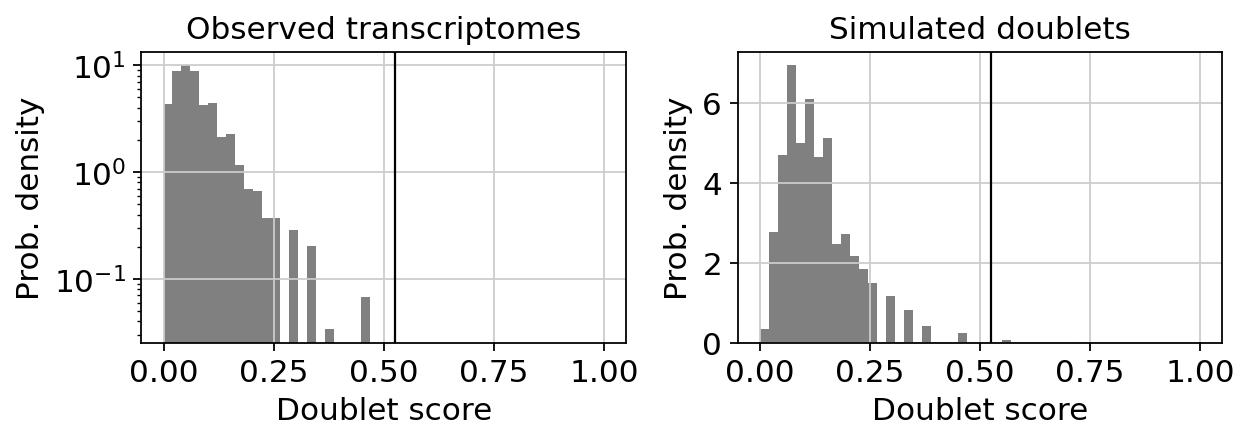

In [13]:
scrub.plot_histogram();

## START PERFORMING THE INITIAL QUALITY CONTROL

normalizing counts per cell


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


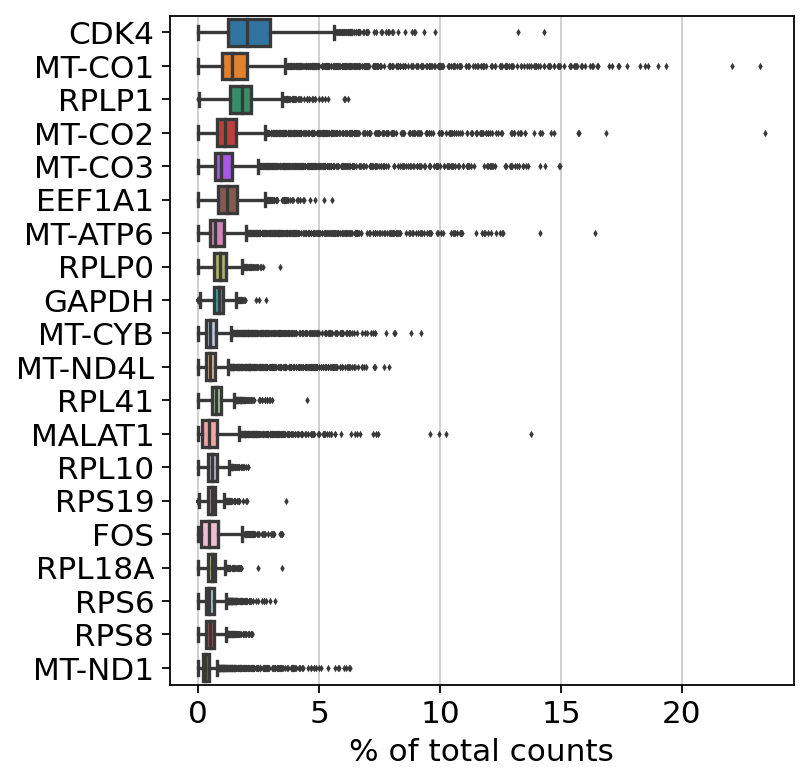

In [14]:
# preprocessing
sc.pl.highest_expr_genes(adata, n_top=20,)

In [15]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 30 cells that have less than 200 genes expressed


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 15128 genes that are detected in less than 3 cells


In [16]:
# calculate some quality metrics as for instance mitochondrial percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# and for ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'patient' as categorical
... storing 'feature_types' as categorical


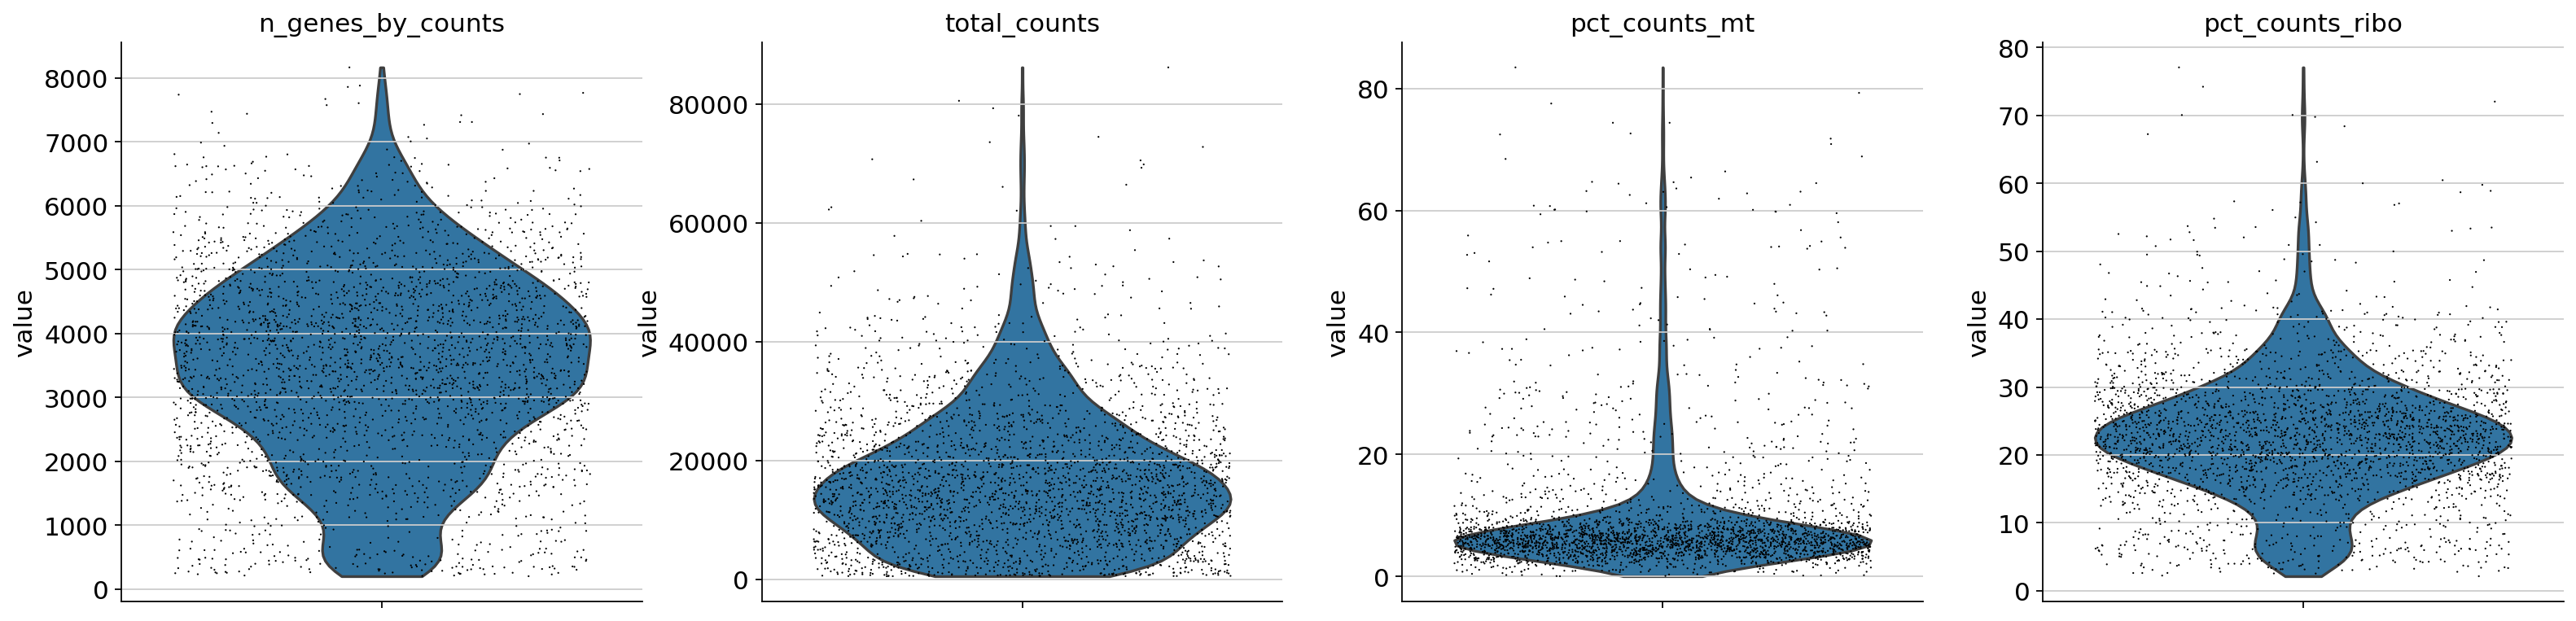

In [17]:
# visualize some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

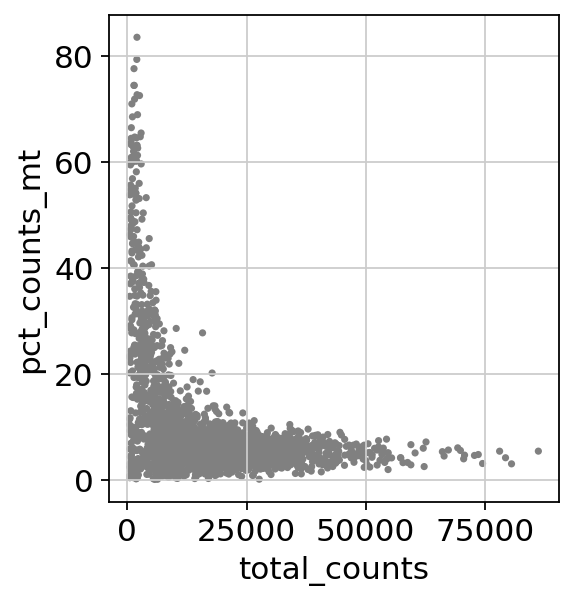

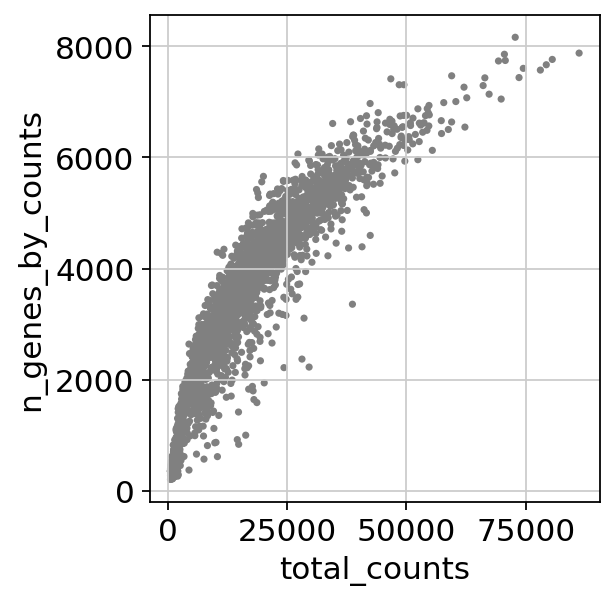

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [19]:
# do the actual filtering by slicing the object
adata = adata[200 < adata.obs.n_genes_by_counts, :]
adata = adata[500 < adata.obs.total_counts, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.pct_counts_ribo < 40, :]

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [20]:
adata

View of AnnData object with n_obs × n_vars = 1613 × 17610
    obs: 'sample', 'technology', 'patient', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [21]:
# calculate mean number of genes detected
mean_genes = adata.obs['n_genes'].mean()
print(mean_genes)

# calculate mean number of transcripts detected
mean_counts = adata.obs['total_counts'].mean()
print(mean_counts)

3459.2393056416613
14628.056640625


## PERFORM NORMALIZATION, PCA AND CLUSTERING

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
sc.pp.log1p(adata)

In [24]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


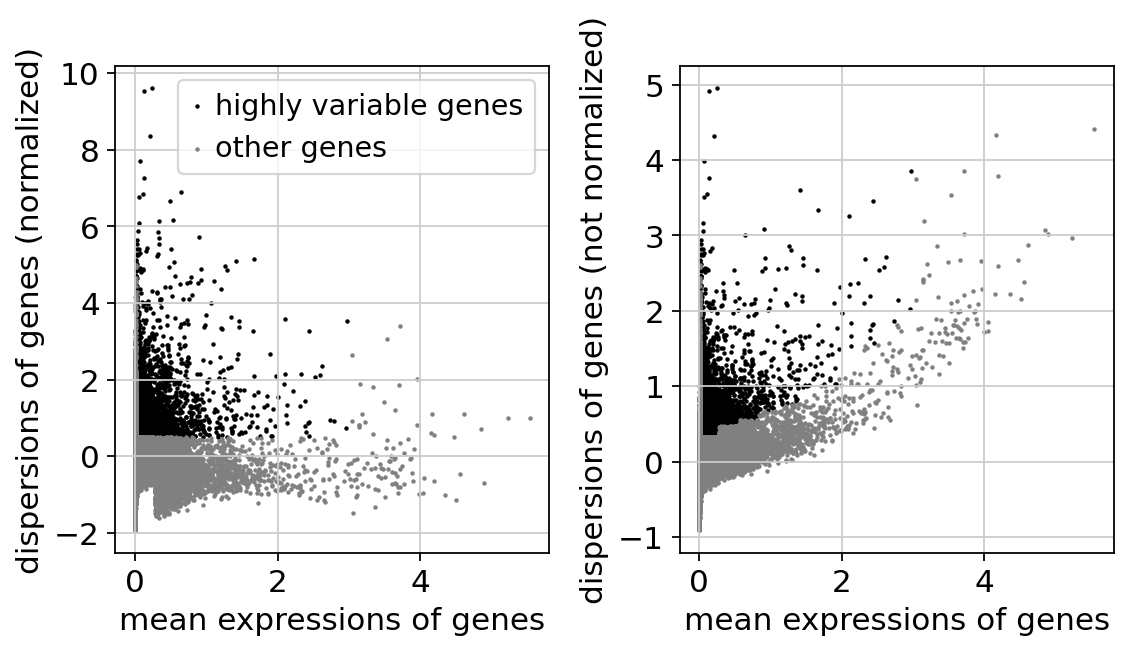

In [25]:
sc.pl.highly_variable_genes(adata)

In [26]:
# set the raw attribute of anndata
adata.raw = adata

In [27]:
adata = adata[:, adata.var.highly_variable]

In [28]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:00:11)


In [29]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


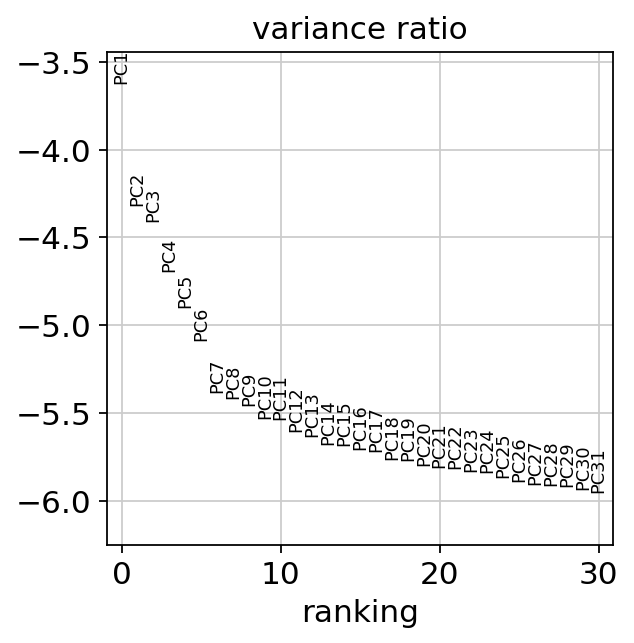

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

In [31]:
# compute nearest neighbors, UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=7)
sc.tl.umap(adata, n_components=2, min_dist=0.1,  # Scanpy default = 0.05
           spread=1.0, copy=False, random_state=0)
sc.tl.louvain(adata, resolution= 0.2)
sc.tl.leiden(adata, resolution= 0.1)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


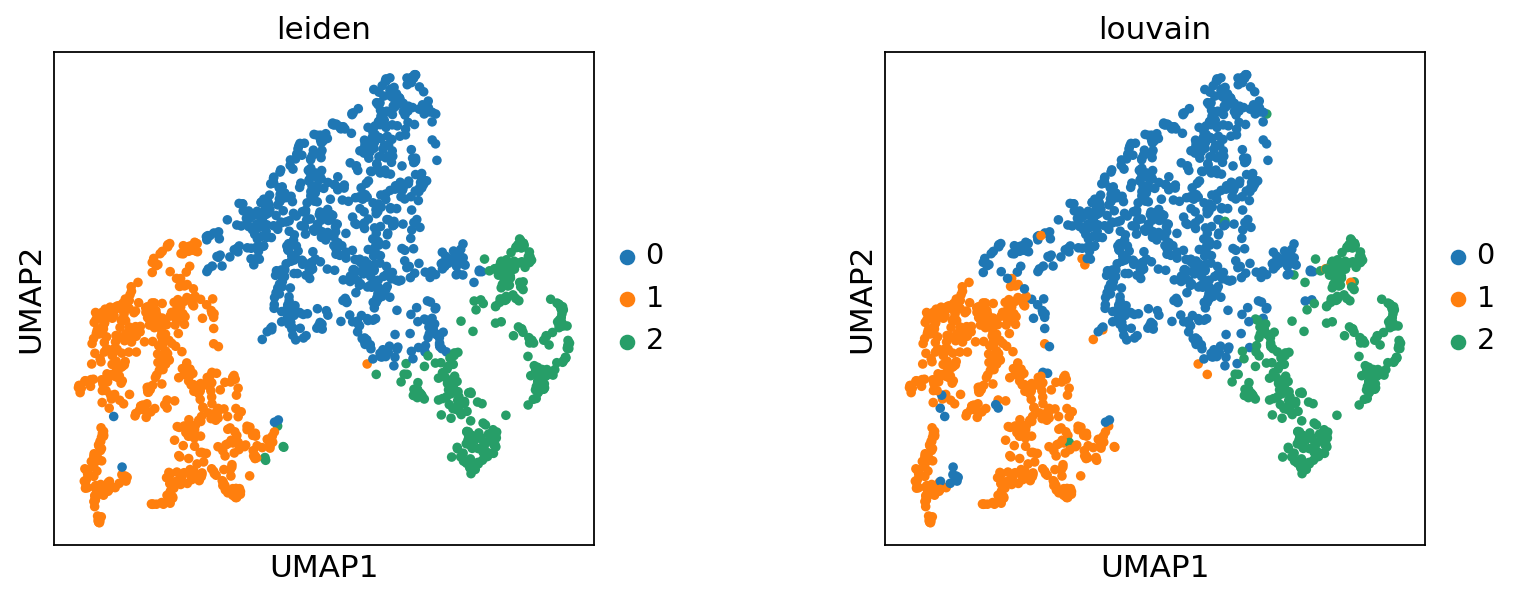

In [32]:
sc.pl.umap(adata, color=['leiden', 'louvain',], save = '_RCMB18-PDX.pdf', wspace = 0.4)

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


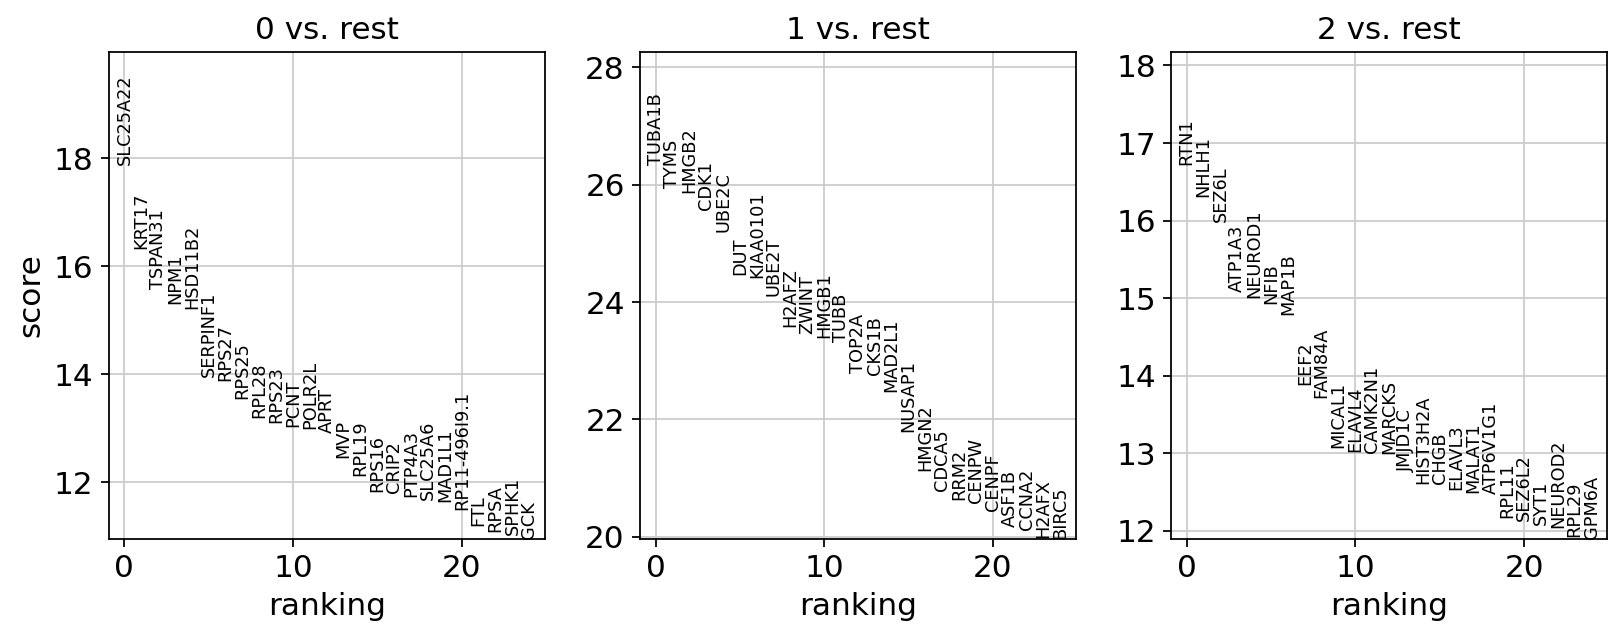

In [33]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_RCMB18-PDX_leiden.pdf")

In [34]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2
0,SLC25A22,TUBA1B,RTN1
1,KRT17,TYMS,NHLH1
2,TSPAN31,HMGB2,SEZ6L
3,NPM1,CDK1,ATP1A3
4,HSD11B2,UBE2C,NEUROD1


In [35]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [36]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/RCMB18-PDX_DEG_wilcoxon.csv")

In [37]:
new_cluster_names = ['cluster0', 'cluster1', 'cluster2']
adata.rename_categories('leiden', new_cluster_names)

old_to_new = dict(
    cluster0='malignant SHH',
    cluster1='malignant cycling',
    cluster2='neuronal development'
)

adata.obs['new_clusters'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


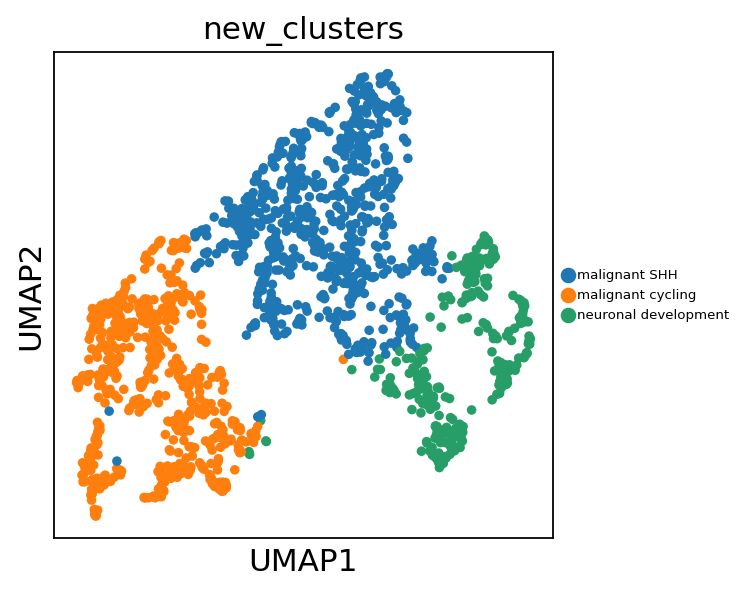

In [38]:
sc.pl.umap(adata, color=['new_clusters'], save = '_RCMB18-PDX_CellType.pdf', wspace = 0.6, legend_fontsize = 6)

In [39]:
adata.write("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/RCMB18-PDX_Celltype_scanpy.h5ad")

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [40]:
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/RCMB18-PDX_metadata.csv')

In [41]:
## PROJECT ALIGNED SCDNA CLONES ONTO THE EMBEDDING

In [19]:
adata = sc.read("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpyRCMB18-PDX_Celltype_scanpy.h5ad")

In [42]:
adata.obs

,sample,technology,patient,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,louvain,leiden,new_clusters
AAACCTGAGCGTGAAC-1,RCMB18,PDX,RCMB18,3489,3489,17372.0,1182.0,6.804053,5459.0,31.424131,0,cluster0,malignant SHH
AAACCTGAGCTGGAAC-1,RCMB18,PDX,RCMB18,4256,4254,14747.0,1287.0,8.727199,2134.0,14.470739,0,cluster0,malignant SHH
AAACCTGGTAAACCTC-1,RCMB18,PDX,RCMB18,3529,3527,13861.0,955.0,6.889835,3305.0,23.843878,0,cluster0,malignant SHH
AAACGGGAGCCGTCGT-1,RCMB18,PDX,RCMB18,2338,2338,7293.0,569.0,7.802002,1308.0,17.935007,1,cluster1,malignant cycling
AAACGGGCATAGTAAG-1,RCMB18,PDX,RCMB18,3020,3020,11442.0,762.0,6.659675,2335.0,20.407272,0,cluster0,malignant SHH
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCCATCGGGTC-1,RCMB18,PDX,RCMB18,2994,2993,9250.0,409.0,4.421621,1717.0,18.562162,0,cluster0,malignant SHH
TTTGGTTAGAAGGTGA-1,RCMB18,PDX,RCMB18,3310,3309,16491.0,951.0,5.766782,5839.0,35.407192,1,cluster1,malignant cycling
TTTGTCAAGATAGGAG-1,RCMB18,PDX,RCMB18,4583,4582,23449.0,1423.0,6.068489,5793.0,24.704678,1,cluster1,malignant cycling
TTTGTCAAGTAACCCT-1,RCMB18,PDX,RCMB18,4693,4692,24816.0,1373.0,5.532721,6055.0,24.399582,2,cluster0,malignant SHH


## PROJECT ALIGNED SCDNA CLONES ONTO THE EMBEDDING

In [43]:
scDNA_clones = pd.read_csv("/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/RCMB18-PDX/RCMB18-PDX_scDNA_clones_filtered_cells.txt", sep = '\t', index_col=0)
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone1_pval,Clone2_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,
TGCGCAGGTATTACCG-1,Clone1,0.115241,0.115241,-0.004961,0.001,1.001,0,0.001,0.002
CGATTGATCCTGCCAT-1,Clone1,0.418926,0.418926,0.402048,0.191,0.786,0,0.191,0.382
GTGCGGTGTCTCGTTC-1,Clone1,0.420052,0.420052,0.376914,0.001,1.000,0,0.001,0.002
AGAATAGTCTGGTTCC-1,Clone1,0.487516,0.487516,0.430404,0.001,1.001,0,0.001,0.002
CAGAGAGAGTTAGGTA-1,Clone1,0.443969,0.443969,0.397829,0.003,0.997,0,0.003,0.006
...,...,...,...,...,...,...,...,...,...
AACTCTTTCAGTCCCT-1,Clone2,0.515400,0.448292,0.515400,1.000,0.005,0,0.005,0.010
CGGAGCTTCCTGCAGG-1,Clone2,0.473947,0.435228,0.473947,0.970,0.057,0,0.057,0.114
TGCTGCTTCCAAATGC-1,Clone2,0.443566,0.427917,0.443566,0.756,0.242,0,0.242,0.484


In [44]:
scDNA_clones = scDNA_clones.loc[scDNA_clones['padj'] <= 0.05, :]
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone1_pval,Clone2_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,
TGCGCAGGTATTACCG-1,Clone1,0.115241,0.115241,-0.004961,0.001,1.001,0,0.001,0.002
GTGCGGTGTCTCGTTC-1,Clone1,0.420052,0.420052,0.376914,0.001,1.000,0,0.001,0.002
AGAATAGTCTGGTTCC-1,Clone1,0.487516,0.487516,0.430404,0.001,1.001,0,0.001,0.002
CAGAGAGAGTTAGGTA-1,Clone1,0.443969,0.443969,0.397829,0.003,0.997,0,0.003,0.006
ATGTGTGCAGGCTGAA-1,Clone1,0.568761,0.568761,0.499442,0.001,1.001,0,0.001,0.002
...,...,...,...,...,...,...,...,...,...
GTCTTCGGTTATGCGT-1,Clone2,0.411020,0.356054,0.411020,0.993,0.018,0,0.018,0.036
GGCCGATGTCGCGTGT-1,Clone2,0.429299,0.372057,0.429299,0.994,0.014,0,0.014,0.028
GTCGTAAAGTTGAGTA-1,Clone2,0.402457,0.348852,0.402457,0.993,0.020,0,0.020,0.040


In [45]:
adata.obs['clone_id'] = scDNA_clones['clone_id']
adata.obs['padj'] = scDNA_clones['padj']

In [46]:
adata.uns['clone_id_colors'] = np.array(["#E41A1C", "#377EB8", "#808080"])

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'clone_id' as categorical


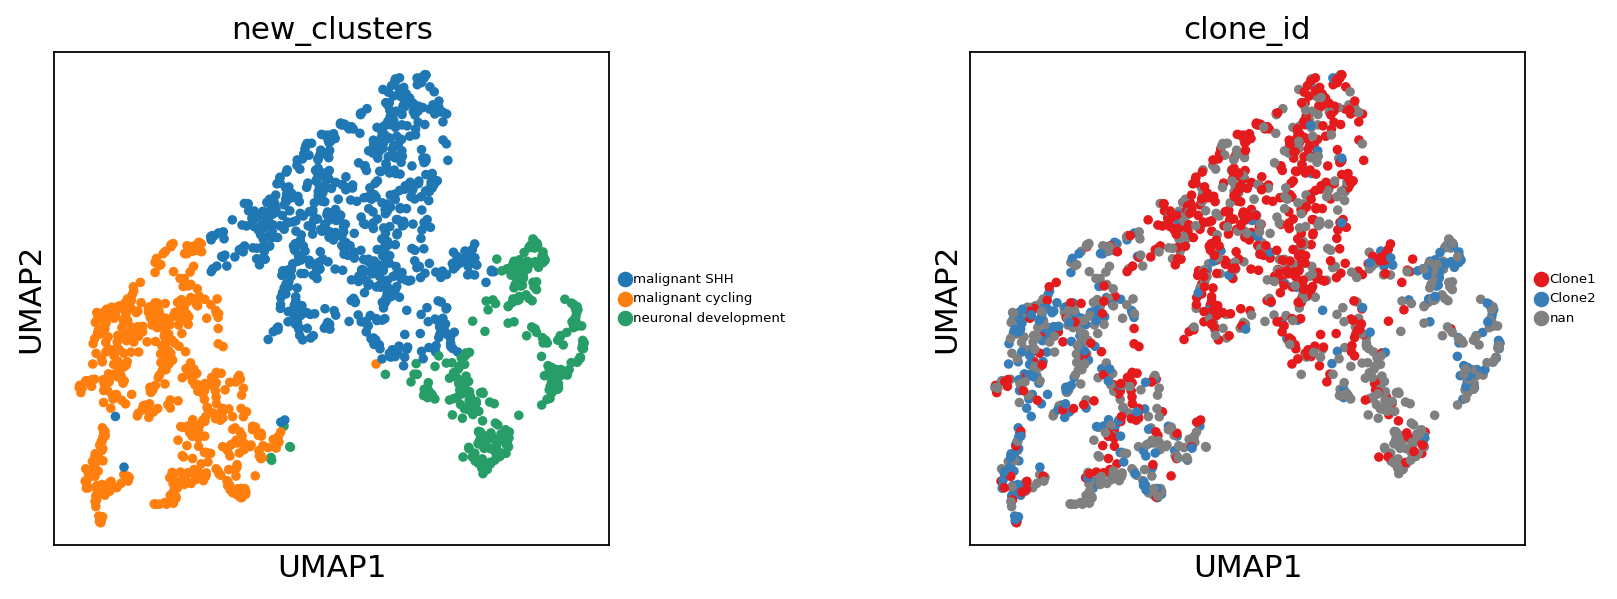

In [47]:
sc.pl.umap(adata, color=['new_clusters', 'clone_id'], save = '_RCMB18-PDX_scDNA_clones_integrated.pdf', wspace = 0.5, legend_fontsize = 6)

In [48]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/infercnv_MB/RCMB18-PDX_metadata.csv')

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


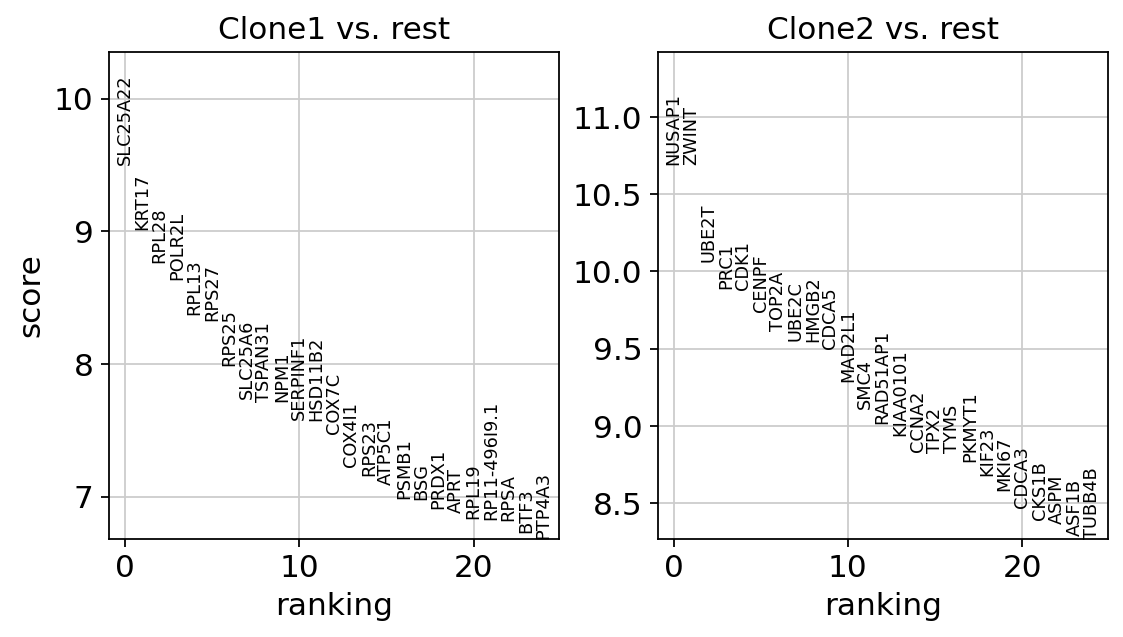

In [49]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(
            adata,
            groupby='clone_id',
            groups=['Clone1', 'Clone2'],
            reference='rest',
            use_raw=True,
            method='wilcoxon',
            n_genes=2000,
            corr_method='benjamini-hochberg'
        )
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [50]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges','scores', "pvals", 'pvals_adj']})

In [51]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/RCMB18-PDX_DEG_wilcoxon_integrated_scDNA_clones_only.csv")

In [52]:
wilcoxon_df

,Clone1_n,Clone1_l,Clone1_s,Clone1_p,Clone2_n,Clone2_l,Clone2_s,Clone2_p
0,SLC25A22,0.561715,9.504119,3.552789e-17,NUSAP1,1.576702,10.693867,1.001033e-22
1,KRT17,0.974685,9.012936,1.177596e-15,ZWINT,1.438256,10.689740,1.001033e-22
2,RPL28,0.238614,8.766133,8.140567e-15,UBE2T,1.086980,10.059953,3.655746e-20
3,POLR2L,0.398186,8.637886,2.016800e-14,PRC1,1.415315,9.886831,1.449317e-19
4,RPL13,0.244973,8.371149,1.522478e-13,CDK1,1.514261,9.882904,1.449317e-19
...,...,...,...,...,...,...,...,...
1995,CRTC1,0.116702,0.338156,1.000000e+00,TXN,0.174546,2.036525,3.182908e-01
1996,CWC27,0.066913,0.337936,1.000000e+00,SMIM7,0.276700,2.035659,3.188157e-01
1997,LATS2,1.416154,0.337771,1.000000e+00,GRM8,1.621907,2.034994,3.188249e-01
1998,ZNF23,0.183327,0.337661,1.000000e+00,BOP1,0.202035,2.034927,3.188249e-01


## PROJECT CHROMOTHRIPSIS SIGNATURE ONTO THE EMBEDDING

In [10]:
f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/MB_shh_filtered_table_FDR.tsv"
pos_df=pd.read_table(f, sep='\t')
pos_df=pos_df.loc[pos_df['log2FoldChange'] > 0,:]
pos_df=pos_df.loc[pos_df['padj'] <= 0.05,:]
neg_df=pd.read_table(f, sep='\t')
neg_df=neg_df.loc[neg_df['log2FoldChange'] < 0,:]
neg_df=neg_df.loc[neg_df['padj'] <= 0.05,:]

In [11]:
pos_df
neg_df

,ens_fullid,ens_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
409,ENSG00000187097.12_3,ENSG00000187097,1662.242563,-0.359350,0.109875,-3.270523,1.073486e-03,0.036798,ENTPD5
410,ENSG00000250462.8_2,ENSG00000250462,1332.612360,-0.407023,0.128259,-3.173454,1.506366e-03,0.045176,LRRC37BP1
411,ENSG00000076242.14_2,ENSG00000076242,4657.937488,-0.414492,0.112141,-3.696177,2.188700e-04,0.013763,MLH1
412,ENSG00000113812.13_3,ENSG00000113812,6868.479447,-0.436607,0.127945,-3.412451,6.438160e-04,0.026346,ACTR8
413,ENSG00000100890.15_3,ENSG00000100890,808.125224,-0.443807,0.140809,-3.151842,1.622438e-03,0.047158,KIAA0391
...,...,...,...,...,...,...,...,...,...
1042,ENSG00000237869.2,ENSG00000237869,12.804303,-5.767545,1.786001,-3.229307,1.240907e-03,0.040182,RP11-459O16.1
1043,ENSG00000183072.9_2,ENSG00000183072,260.545238,-5.943601,1.123514,-5.290188,1.220000e-07,0.000112,NKX2-5
1044,ENSG00000266736.1_2,ENSG00000266736,102.835417,-6.129589,1.766502,-3.469902,5.206490e-04,0.023260,RP11-260A9.4
1045,ENSG00000253226.1_2,ENSG00000253226,23.377382,-6.273874,1.701660,-3.686913,2.269910e-04,0.014047,HAUS1P3


In [12]:
gene_list_pos=pos_df['gene_name']
intersect_gene_list_pos=adata.var_names.isin(list(gene_list_pos))
gene_list_pos=adata.var_names[intersect_gene_list_pos]

In [13]:
len(gene_list_pos)

64

In [14]:
gene_list_neg=neg_df['gene_name']
intersect_gene_list_neg=adata.var_names.isin(list(gene_list_neg))
gene_list_neg=adata.var_names[intersect_gene_list_neg]

In [15]:
len(gene_list_neg)

53

In [16]:
sc.tl.score_genes(adata, list(gene_list_pos), ctrl_size=len(gene_list_pos), gene_pool=None, n_bins=25, score_name='Upregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, list(gene_list_neg), ctrl_size=len(gene_list_neg), gene_pool=None, n_bins=25, score_name='Downregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)

computing score 'Upregulated_Chromothripsis_Score'
    finished: added
    'Upregulated_Chromothripsis_Score', score of gene set (adata.obs).
    1371 total control genes are used. (0:00:00)
computing score 'Downregulated_Chromothripsis_Score'
    finished: added
    'Downregulated_Chromothripsis_Score', score of gene set (adata.obs).
    1036 total control genes are used. (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


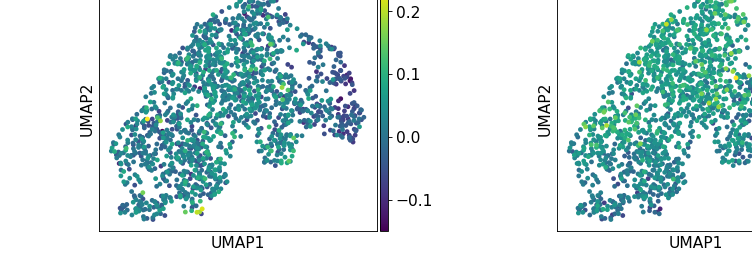

In [17]:
sc.pl.umap(adata, color=['Upregulated_Chromothripsis_Score', 'Downregulated_Chromothripsis_Score'], save = '_RCMB18-PDX_chromothripsisScore.pdf', wspace = 0.5)

In [13]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/RCMB18-PDX_chromothripsisScore_metadata.csv')

In [14]:
metadata

,sample,technology,patient,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,louvain,leiden,new_clusters,clone_id,padj
AAACCTGAGCGTGAAC-1,RCMB18,PDX,RCMB18,3489,3489,17372.0,1182.0,6.804053,5459.0,31.424131,0,cluster0,malignant SHH,Clone1,0.002
AAACCTGAGCTGGAAC-1,RCMB18,PDX,RCMB18,4256,4254,14747.0,1287.0,8.727199,2134.0,14.470739,0,cluster0,malignant SHH,Clone2,0.036
AAACCTGGTAAACCTC-1,RCMB18,PDX,RCMB18,3529,3527,13861.0,955.0,6.889835,3305.0,23.843878,0,cluster0,malignant SHH,Clone1,0.010
AAACGGGAGCCGTCGT-1,RCMB18,PDX,RCMB18,2338,2338,7293.0,569.0,7.802002,1308.0,17.935007,1,cluster1,malignant cycling,Clone1,0.002
AAACGGGCATAGTAAG-1,RCMB18,PDX,RCMB18,3020,3020,11442.0,762.0,6.659675,2335.0,20.407272,0,cluster0,malignant SHH,Clone1,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCCATCGGGTC-1,RCMB18,PDX,RCMB18,2994,2993,9250.0,409.0,4.421621,1717.0,18.562162,0,cluster0,malignant SHH,nan,NaN
TTTGGTTAGAAGGTGA-1,RCMB18,PDX,RCMB18,3310,3309,16491.0,951.0,5.766782,5839.0,35.407192,1,cluster1,malignant cycling,nan,NaN
TTTGTCAAGATAGGAG-1,RCMB18,PDX,RCMB18,4583,4582,23449.0,1423.0,6.068489,5793.0,24.704678,1,cluster1,malignant cycling,Clone2,0.032
TTTGTCAAGTAACCCT-1,RCMB18,PDX,RCMB18,4693,4692,24816.0,1373.0,5.532721,6055.0,24.399582,2,cluster0,malignant SHH,nan,NaN


In [15]:
data_crosstab = pd.crosstab(metadata['new_clusters'], metadata['clone_id'], margins = False)
print(data_crosstab)

clone_id              Clone1  Clone2  nan   
new_clusters                                
malignant SHH            466      46     231
malignant cycling        116     205     240
neuronal development      31      75     203


In [16]:
data_crosstab.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/RCMB18-PDX_contingencyTable_celltypes_clones.csv')